In [102]:
import sys
print(sys.path)

['', 'C:\\Users\\Loes\\Anaconda2\\python27.zip', 'C:\\Users\\Loes\\Anaconda2\\DLLs', 'C:\\Users\\Loes\\Anaconda2\\lib', 'C:\\Users\\Loes\\Anaconda2\\lib\\plat-win', 'C:\\Users\\Loes\\Anaconda2\\lib\\lib-tk', 'C:\\Users\\Loes\\Anaconda2', 'C:\\Users\\Loes\\Anaconda2\\lib\\site-packages', 'C:\\Users\\Loes\\Anaconda2\\lib\\site-packages\\Babel-2.5.0-py2.7.egg', 'C:\\Users\\Loes\\Anaconda2\\lib\\site-packages\\win32', 'C:\\Users\\Loes\\Anaconda2\\lib\\site-packages\\win32\\lib', 'C:\\Users\\Loes\\Anaconda2\\lib\\site-packages\\Pythonwin', 'C:\\Users\\Loes\\Anaconda2\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\Loes\\.ipython']


In [103]:
#bron: https://musicinformationretrieval.com/feature_sonification.html

%matplotlib inline
import numpy, scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display
plt.rcParams['figure.figsize'] = (13, 5)

# Step 1: Retrieve Audio

In [104]:
import os

In [105]:
folder = r'C:\Users\Loes\Documents\GitHub\Projectstage\audiovoorbeelden\heartbeat-sounds\set_a'
files = [filename for filename in files[:5] for _, _, files in os.walk(folder)]

In [106]:
#Load the audio file simple_loop.wav into an array. With amplitude as values
x, sr = librosa.load(os.path.join(folder, files[1]), sr=None) #sr is sampling rate
#Listen to audio file
ipd.Audio(x, rate=sr)

In [382]:
#Duration audio file
print('duration: {}s'.format(len(x)/sr))
#Show the sample rate
print("sample rate: {}Hz".format(sr))

duration: 9s
sample rate: 44100Hz


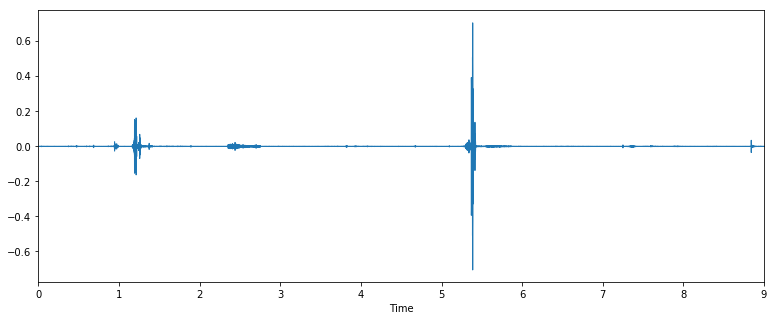

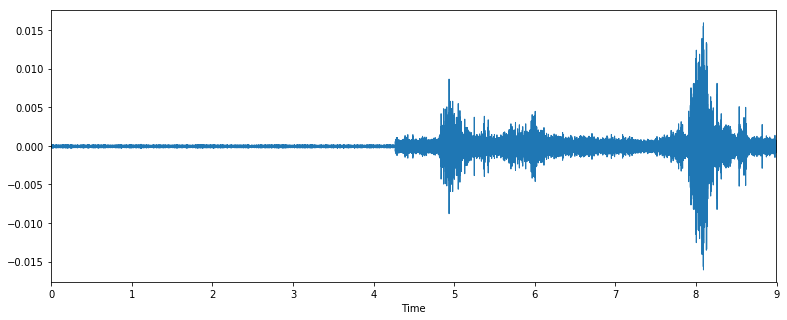

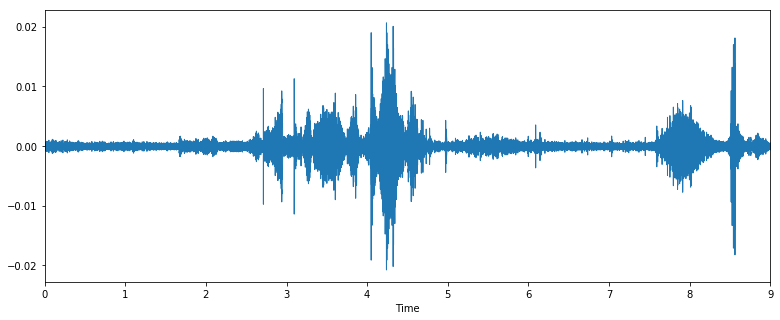

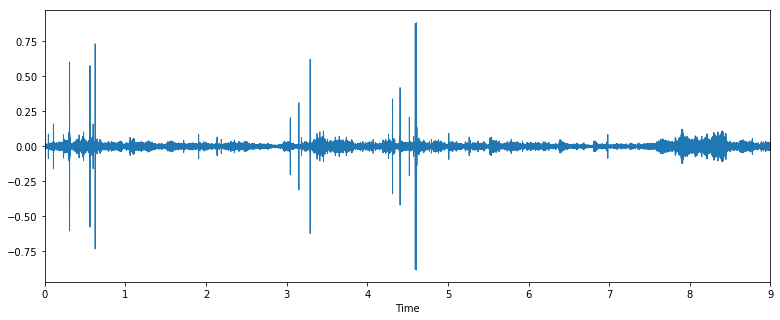

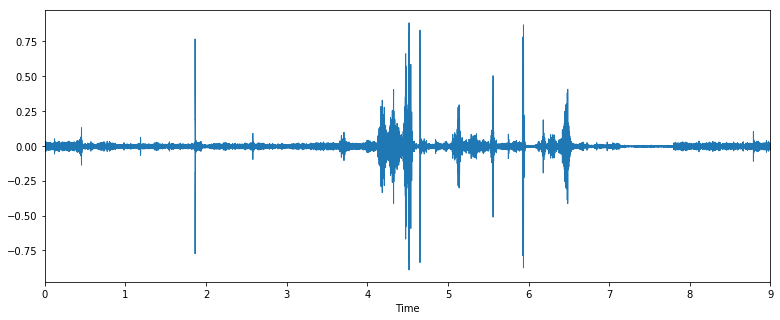

In [383]:
x_list = []
sr_list = []
for filename in files:
    x, sr = librosa.load(os.path.join(folder, filename), sr=None) #sr is sampling rate
    x_list.append(x)
    sr_list.append(sr)
    plt.figure()
    librosa.display.waveplot(x, sr=sr)

In [114]:
x_all = numpy.asarray(x_list)
sr_all = numpy.asarray(sr_list)

[44100 44100 44100 44100 44100]


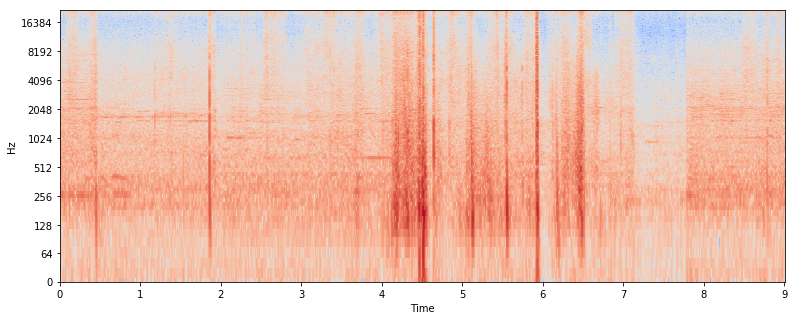

In [117]:
X_list = []

for x in x_all:
    #Compute the short-time Fourier transform:
    X = librosa.stft(x)
    X_list.append(X)
    #For display purposes, compute the log amplitude of the STFT:
    Xmag = librosa.power_to_db(X)
    #Display the spectrogram
    # Play with the parameters, including x_axis and y_axis
    librosa.display.specshow(Xmag, sr=sr, x_axis='time', y_axis='log')

# Step 2: Detect Onsets

In [156]:
frame_sz = int(0.100*sr)
segments_list = []

for x in x_all:
    #Find the times, in seconds, when onsets occur in the audio signal.
    onset_frames = librosa.onset.onset_detect(x, sr=sr)
    onset_times = librosa.frames_to_time(onset_frames, sr=sr)
    #Convert the onset frames into sample indices.
    onset_samples = librosa.frames_to_samples(onset_frames)
    
    #----Segment the Audio----------
    segments_list.append(numpy.array([x[i:i+frame_sz] for i in onset_samples]))

# Step 3: Segment the Audio

In [319]:
#Here is a function that adds 300 ms of silence onto the end of each segment and concatenates them into one signal.
#Later, we will use this function to listen to each segment, perhaps sorted in a different order.
def concatenate_segments(segments_list, sr=22050, pad_time=0.300):
    padded_segments = []
    conc_signal = []
    for segments in segments_list:
        padded_segments.append([numpy.concatenate([segment, numpy.zeros(int(pad_time*sr))]) for segment in segments])
    for padded_segment in padded_segments:
        conc_signal.append(numpy.concatenate(padded_segment))
    return conc_signal

In [324]:
concatenated_signal = concatenate_segments(segments_list, sr)

# Step 4: Extract Features

In [334]:
zero_crossing_rate_list = []
for segments in segments_list:
    #For each segment, compute the zero crossing rate.
    zero_crossing_rate_list.append([sum(librosa.core.zero_crossings(segment)) for segment in segments])

In [341]:
ind_list = []
for zcrs in zero_crossing_rate_list:  
    #Use argsort to find an index array, ind, such that segments[ind] is sorted by zero crossing rate.
    ind_list.append(numpy.argsort(zcrs))

In [377]:
segments_zcrs = []
for i in range(len(segments_list)):
    segments_zcrs.append(segments_list[i][ind_list[i]])

#Sort the segments by zero crossing rate, and concatenate the sorted segments.
concatenated_signal = concatenate_segments(segments_zcrs, sr)

In [378]:
concatenated_signal

[array([-0.00119019, -0.0010376 , -0.00027466, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.00021362, -0.00015259, -0.00079346, ...,  0.        ,
         0.        ,  0.        ]),
 array([-0.00152588, -0.00134277, -0.00106812, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.0062561 ,  0.00799561,  0.00860596, ...,  0.        ,
         0.        ,  0.        ]),
 array([ 0.10287476,  0.08938599,  0.08041382, ...,  0.        ,
         0.        ,  0.        ])]

# Step 5: Listen to Segments

In [60]:
#Listen to the sorted segments. What do you hear?
ipd.Audio(concatenated_signal, rate=sr)

#### Repeat the steps above using other features from librosa.feature, e.g. rmse, spectral_centroid, spectral_bandwidth.